# Load & Insert Promoter
1. load genes from gtf (HBB)
2. extract interval and delete promoter sites
3. insert new promoter to 2.

In [1]:
from IPython.display import clear_output
! pip install alphagenome python-dotenv
clear_output()

## load sequence from gtf

In [2]:
from alphagenome import colab_utils
from alphagenome.data import gene_annotation, genome, track_data, transcript
from alphagenome.data.track_data import TrackData
from alphagenome.models import dna_client
from alphagenome.visualization import plot_components
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [10]:
import sys
from pathlib import Path

# Allow importing utils from project subdir.
sys.path.append(str(Path('..').resolve()))

from utils import (
    get_dna_model,
    get_output_metadata,
    load_gtf_feather,
    prepare_gtf_views,
    build_transcript_extractors,
)

dna_model = get_dna_model()
output_metadata = get_output_metadata(dna_model)

gtf = load_gtf_feather()
gtf_transcript, gtf_longest_transcript = prepare_gtf_views(gtf)
transcript_extractor, longest_transcript_extractor = (
    build_transcript_extractors(gtf_transcript, gtf_longest_transcript)
)


In [11]:
# Zoom in on the region around APOL4.
apol4_interval = gene_annotation.get_gene_interval(gtf, gene_symbol='APOL4')

# Add 1KB on either side of the gene body.
apol4_interval.resize_inplace(apol4_interval.width + 1000)

apol4_interval.width
# example: HBB
HBB_interval = gene_annotation.get_gene_interval(gtf, gene_symbol='HBB')
HBB_interval

Interval(chromosome='chr11', start=5225463, end=5229395, strand='-', name='HBB')

## load promoter from DNA foundation model

In [12]:
PROMOTER_PATH = DATA_DIR / 'promoters'

MODEL='NT-v2-500m' # DNABERT-2, NT-v2-50m, NT-v2-500m
GENE='HBB'

# 경로 생성
file_path = f"{PROMOTER_PATH}/{MODEL}/{GENE}_promoter.csv"

# 불러오기
df = pd.read_csv(file_path, index_col=0)
df.head()

,iteration_0,iteration_1,iteration_2,iteration_3,iteration_4,iteration_5,iteration_6,iteration_7,iteration_8,iteration_9,...,iteration_21,iteration_22,iteration_23,iteration_24,iteration_25,iteration_26,iteration_27,iteration_28,iteration_29,iteration_30
greedy,GAACTTGAATCAAGGAAATGATTTTAAAACGCAGTATTCTTAGTGG...,GAACTTGAATCAAGGAAATGATTTTAAAACTTTTTTTTCTTAGTGG...,GAACTTGAATCAATGAAATTTTTTTAAAACTTTTTTTTCTTAGTGG...,GAACTTGAATCAATGAAATTTTTTTAAAACTTTTTTTTCTTAGTGG...,GAACTTGAATCAATGAAACTTTTTTTTTTTTTTTTTTTCTTAGTGG...,GAACTTGAATCAGTTAGACTTTTTTTTTTTTTTTTTTTCTTAGTGG...,GAACTTATTTAGTTTTTTCTTTTTTTTTTTTTTTTTTTTTTTCCAA...,TTTTTTATTTAGTTTTTTCTTTTTTTTTTTTTTTTTTTTTTTTTTT...,TTTTTTATTTAGTTTTTTCTTTTTTTTTTTTTTTTTTTTTTTTTTT...,TTTTTTTTTTTTTTTTTTCTTTTTTTTTTTTTTTTTTTTTTTTTTT...,...,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTATTAAAGCTGTGAT...,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTATTAAAGCTGTGAT...,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTATTAAAGCTGTGAT...,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTATTAAAGCTGTGAT...,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTATTAAAGCTGTGAT...,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTATTAAAGCTGTGAT...,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTATTAAAGCTGTGAT...,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTATTAAAGCTGTGAT...,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTATTAAAGCTGTGAT...,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTATTAAAGCTGTGAT...
sampling_t0.5,GAACTTGAATCAAGGAAATGATTTTAAAACGCAGTATTCTTAGTGG...,ACCACTGAATCAAGGAAAAAAAAATAAAACTTTGATTTCTTAGTGG...,ACCACTTTTTTTTTTTTTAAAAAATAAAACTTTGATTTCTTACATT...,ACCACTTTTTTTTTTTTTAAAAAATAAAACTTCTTTTTCTTACATT...,ACCACTTTTTATTTTTTTAAAAAATAAAACTTCTTTTTCTTACATT...,CAAAATTTTTATAATAAAAAAAAATAAAACAAAAAAAAAAAACATT...,AAAAAAAAAAAAAAAAAAAAAAAATAAAACAAAAAAAAAAAAAAAA...,AAAAAAAAAAAAAAAAAAAAAAAATAAAACAAAAAAAAAAAAAAAA...,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,...,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,AAACAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,AAACAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...
sampling_t1.0,GAACTTGAATCAAGGAAATGATTTTAAAACGCAGTATTCTTAGTGG...,GAACTTGAATCAAGGAAATGATTTTAAAACGCAGTATTCTTAAGAT...,GAACTTAGCACAGGACAGTGATTTTTTTTTGCAGTATTCTTAAGAT...,GAACTTAGCACATGATTTTGATTTTTTTTTGCAGTAATGAAAAGAT...,GAACTTAGCACATGATTTTGATTTTTTTTTGCAGTATAATTAAGAT...,GAACTTAGCACATGATTTTGATTTTTTTTTGCAGTATAATTAAGAT...,GAACTTTGATTTTAGATTTGATTTTTTTTTGCAGTATAATTAAGAT...,GAACTTTGATTTTAGATTTGATTTTTTTTTGCAGTAATGTTAAGAT...,GAACTTTGATTTTAGATTTGATTTTTTTTTTCAGAAATGTTAAGAT...,GAACTTTGATTTCTAAATTAGATATTTTTTTCAGAAATCTCGAGAT...,...,GAACTTTTACATTATTATACATTGAGTTTTCATGCTCTACCTAGAG...,GAACTTTTACATTATTATACATTGAGTTTTCATGTTCTACCTGAGC...,GAACTTTTACATTATTATACATTGAGTTTTCATGTTCTACCGCGAT...,AGGAACTTACATACTAAATGTGTAAGTTTTCATGTTTTCAAACGAT...,AGGAACTTACATACTAAATGTGTAAGTTTTCATGTTTTCAAATTAG...,AGGAACTTACATACTAAATGTGTAAGTTTTCATGTTTTCAAAAATC...,AGGAACTTACATACTAAATGTGTAAGTTTTCATGTTTTCAAAAATC...,GATCGTTTACATATTATATGTGTAAGTTTTCATGTTTTCAAAAATC...,GATCGTTTACATATTATATGTGTAAGTTTTCATGTTTTCAAAATTG...,AATATTTTACATATTATATGTGTAAGTTTTCATGTTTTCAAAATTG...
sampling_t1.5,GAACTTGAATCAAGGAAATGATTTTAAAACGCAGTATTCTTAGTGG...,TAGAAAGAATCAATATCCGATGTGTAAAACGACGCATTCTTAGTGG...,TAGAAAGAATCACAGGACGATGTGTAAAACGACGCAGAAACCGTGG...,CTGGCAGAATCACAGGACGATGTGTAAAACGACGCAGAAACCAGCC...,CTGGCAGAATCACAGGACGATGTGTAAAACGACGCAGAAACCAGCC...,CTGGCAGAATCACAGGACGATGTGTAAAACGACGCAGAAACCAGCC...,ATTCGTGAATCAAATAATGATGTGTAAAACGACGCAGAAACCAGCC...,GCCAAAGAATCAGAGTGTGATGTGGTCAGGGACGCAGAAACCAGCC...,GCCAAAGAATCAGAGTGTGATGTGGTCAGGAAGAGTGAAACCTCCC...,ATTGTGGAATCAGAGTGTGATGTGGTCAGGAAGAGTGAAACCTCCC...,...,ATCTAGGGGAGGGCGCACCACTTGCGCAAACAGAGGTAGGGTGCCT...,CTCAAACGAAAAGCGCACCACTTGTCTGGGCAGAGGAGCTGGGCCT...,TCTTGCCGAAAAGCGCACCACTTGTCTGGGCAGAGGAGCTGGGCCT...,TCTTGCAACACAGCGCACCACTTGTCCAAT

In [13]:
DECODING_STR='sampling_t1.0'
promo_iter00=df.loc[DECODING_STR, 'iteration_0']
promo_iter10=df.loc[DECODING_STR, 'iteration_10']
promo_iter20=df.loc[DECODING_STR, 'iteration_20']
promo_iter30=df.loc[DECODING_STR, 'iteration_30']

PROMOTER_LENGTH=len(promo_iter00)
print(f"promo_iter00: {promo_iter00[:50]}...{promo_iter00[-50:]}\npromo_iter10: {promo_iter10[:50]}...{promo_iter10[-50:]}\npromo_iter20: {promo_iter20[:50]}...{promo_iter20[-50:]}\npromo_iter30: {promo_iter30[:50]}...{promo_iter30[-50:]}")

promo_iter00: GAACTTGAATCAAGGAAATGATTTTAAAACGCAGTATTCTTAGTGGACTA...CAGGAGCCAGGGCTGGGCATAAAAGTCAGGGCAGAGCCATCTATTGCTTA
promo_iter10: GAACTTCTTTAAATAGCTTAGATATTTTTTTCAGAAATCTCGAGATACTA...GGTTATGCATAATAAAATAGTTTCGGAATTTAGATTTGAGATATTTTTCG
promo_iter20: GAACTTTTACATTATTATGCGATGAGTTTTCATGCTCTACCTAGAGCTAT...ACCCCCCCCCCAAAAAAAAAAAAGCCCGCCATTTTAGCACAATTAGAAGA
promo_iter30: AATATTTTACATATTATATGTGTAAGTTTTCATGTTTTCAAAATTGCTCG...GGTCCCCCTCCCAAAAAAAAAGGAAAAAGTAAAGAGAATAAAACTTTATT


In [14]:
gtf.columns

Index(['Chromosome', 'Source', 'Feature', 'Start', 'End', 'Score', 'Strand',
       'Frame', 'gene_id', 'gene_type', 'gene_name', 'level', 'tag',
       'transcript_id', 'transcript_type', 'transcript_name',
       'transcript_support_level', 'havana_transcript', 'exon_number',
       'exon_id', 'hgnc_id', 'havana_gene', 'ont', 'protein_id', 'ccdsid',
       'artif_dupl', 'gene_id_nopatch'],
      dtype='object')

In [15]:
chrom_col = 'Chromosome' if 'Chromosome' in gtf.columns else 'chromosome' # Chromosome
start_col = 'Start' if 'Start' in gtf.columns else 'start' # Start
end_col = 'End' if 'End' in gtf.columns else 'end' # End
strand_col = 'Strand' if 'Strand' in gtf.columns else 'strand' # Strand

hbb_gene = gtf[(gtf['gene_name'] == GENE) & (gtf['Feature'] == 'gene')].iloc[0]

gene_id = hbb_gene['gene_id']
chrom = hbb_gene[chrom_col]
# start = int(hbb_gene[start_col])
# end = int(hbb_gene[end_col])
start=5225464
end=5227071
strand = hbb_gene[strand_col]

print(f"{GENE} Gene({gene_id}): {chrom}:{start}-{end} ({strand})")


HBB Gene(ENSG00000244734.4): chr11:5225464-5227071 (-)


In [16]:
ENSEMBL_SPECIES = 'human'
ENSEMBL_ASSEMBLY = 'GRCh38'

def get_sequence_from_ensembl_region(species, chrom, start, end, strand, coord_system_version=None):
    """Half-open interval [start, end) in 1-based coordinates.

    Ensembl REST expects inclusive end, so we convert end -> end-1.
    """
    if end <= start:
        raise ValueError(f'Invalid half-open interval: start={start}, end={end}')

    server = 'https://rest.ensembl.org'
    clean_chrom = str(chrom).replace('chr', '')
    strand_val = 1 if str(strand) in ['+', '1'] else -1
    inclusive_end = end - 1
    region = f"{clean_chrom}:{start}..{inclusive_end}:{strand_val}"
    ext = f"/sequence/region/{species}/{region}"
    if coord_system_version:
        ext = f"{ext}?coord_system_version={coord_system_version}"

    headers = {'Content-Type': 'text/plain'}
    r = requests.get(server + ext, headers=headers)
    r.raise_for_status()
    return r.text.strip()


def normalize_sequence(seq):
    seq = seq.upper()
    normalized = []
    for ch in seq:
        if ch in 'ACGT':
            normalized.append(ch)
        else:
            normalized.append('N')
    return ''.join(normalized)


seq_raw = get_sequence_from_ensembl_region(
    ENSEMBL_SPECIES,
    chrom,
    start,
    end,
    strand,
    coord_system_version=ENSEMBL_ASSEMBLY,
)

seq_normalized = normalize_sequence(seq_raw)
print(f'Sequence length: {len(seq_normalized)}')
print(seq_normalized[:50] + '...')


Sequence length: 1607
CATTTGCTTCTGACACAACTGTGTTCACTAGCAACCTCAAACAGACACCA...


In [17]:
# compare: generated promoter works well
# HBB: negative strand -> promoter starts at 3' end (end+PROMOTER_LENGTH)
ori_seq=normalize_sequence(get_sequence_from_ensembl_region(ENSEMBL_SPECIES,chrom,start,end+PROMOTER_LENGTH,strand,coord_system_version=ENSEMBL_ASSEMBLY))
gen_seq=promo_iter00+seq_normalized

# print(f"ori_seq: {ori_seq[-50:]}\ngen_seq: {gen_seq[-50:]}")
print(f"ori_seq: {ori_seq[:50]}...{ori_seq[-50:]}\ngen_seq: {gen_seq[:50]}...{gen_seq[-50:]}")
# print(len(ori_seq), len(gen_seq))
# print(seq_normalized[:50])

print(f"are they same (ori, gen)? {ori_seq==gen_seq}")

ori_seq: GAACTTGAATCAAGGAAATGATTTTAAAACGCAGTATTCTTAGTGGACTA...CCTTGAGCATCTGGATTCTGCCTAATAAAAAACATTTATTTTCATTGCAA
gen_seq: GAACTTGAATCAAGGAAATGATTTTAAAACGCAGTATTCTTAGTGGACTA...CCTTGAGCATCTGGATTCTGCCTAATAAAAAACATTTATTTTCATTGCAA
are they same (ori, gen)? True


# Compare the result

## Generate results and compare to original

In [18]:
HBB_interval=gene_annotation.get_gene_interval(gtf, gene_id='ENSG00000244734')
# HBB_interval=gene_annotation.get_gene_interval(gtf, gene_symbol="HBB")
print(f"HBB_interval - length: {HBB_interval.width}, start: {HBB_interval.start}, end: {HBB_interval.end}")

HBB_interval.resize_inplace(HBB_interval.width + 2000)
print(f"HBB_interval - length: {HBB_interval.width}, start: {HBB_interval.start}, end: {HBB_interval.end}")

HBB_interval - length: 3932, start: 5225463, end: 5229395
HBB_interval - length: 5932, start: 5224463, end: 5230395


In [19]:
interval=genome.Interval(chrom, start, end+1000, strand='-', name='HBB').resize(
    dna_client.SEQUENCE_LENGTH_1MB
)
interval_vis = interval_vis=genome.Interval(chrom, end-500, end+500, strand='-')

ontology_terms=[
    'EFO:0002067',
    'CL:0000765'
]
requested_outputs={
    dna_client.OutputType.CAGE,
    dna_client.OutputType.CHIP_HISTONE
}

ori_output = dna_model.predict_interval(
    interval=interval.resize(dna_client.SEQUENCE_LENGTH_1MB),
    requested_outputs=requested_outputs,
    ontology_terms=ontology_terms,
)

longest_transcripts = longest_transcript_extractor.extract(interval)
interval,HBB_interval

(Interval(chromosome='chr11', start=4702479, end=5751055, strand='-', name='HBB'),
 Interval(chromosome='chr11', start=5224463, end=5230395, strand='-', name='ENSG00000244734'))

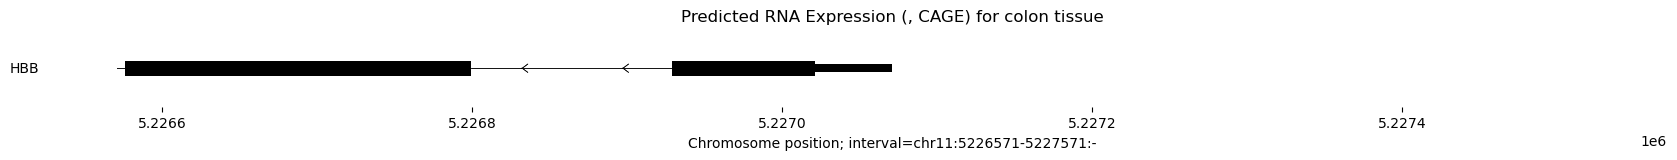

: 

In [ ]:
plot = plot_components.plot(
    [
        plot_components.TranscriptAnnotation(longest_transcripts),
        # plot_components.Tracks(
        #     tdata=ori_output.rna_seq,
        #     ylabel_template='RNA_SEQ: {biosample_name} ({strand})\n{name}',
        # ),
        plot_components.Tracks(
            tdata=ori_output.cage,
            ylabel_template='CAGE: {biosample_name} ({strand})\n{name}',
        ),
        # plot_components.Tracks(
        #     tdata=
        # ),
    ],
    # interval=interval.resize(1000),
    # interval=HBB_interval,
    interval=interval_vis.resize(1000),
    # interval=interval.resize(dna_client.SEQUENCE_LENGTH_100KB),
    title='Predicted RNA Expression (, CAGE) for colon tissue',
)

for negative strand, the generated sequence should be reverse complemented!

In [21]:
def reverse_complement(seq):
    """Return the reverse complement of a DNA sequence."""
    complement_map = {'A': 'T', 'T': 'A', 'G': 'C', 'C': 'G', 'N': 'N'}
    return ''.join(complement_map[base] for base in reversed(seq))

ori_seq_rc = reverse_complement(ori_seq)
print(ori_seq_rc[:50] + '...' + ori_seq_rc[-50:])

TTGCAATGAAAATAAATGTTTTTTATTAGGCAGAATCCAGATGCTCAAGG...TAGTCCACTAAGAATACTGCGTTTTAAAATCATTTCCTTGATTCAAGTTC


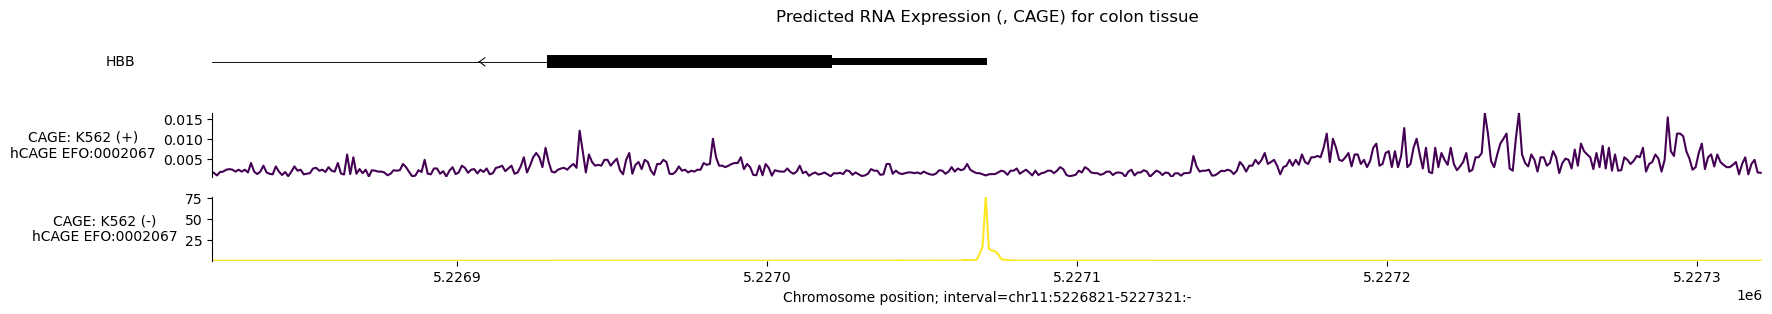

In [22]:
gen_output=dna_model.predict_sequence(
    sequence=ori_seq_rc.center(2**20, 'N'),
    requested_outputs=requested_outputs,
    ontology_terms=ontology_terms,
)

gen_cage = TrackData(
    values=gen_output.cage.values,
    metadata=gen_output.cage.metadata,
    interval=interval,
)

plot=plot_components.plot(
    [
        plot_components.TranscriptAnnotation(longest_transcripts),
        plot_components.Tracks(
            tdata=gen_cage,
            ylabel_template='CAGE: {biosample_name} ({strand})\n{name}',
        ),
    ],
    # interval=interval.resize(1000),
    # interval=HBB_interval,
    interval=interval_vis.resize(500),
    # interval=interval.resize(dna_client.SEQUENCE_LENGTH_100KB),
    title='Predicted RNA Expression (, CAGE) for colon tissue',
)

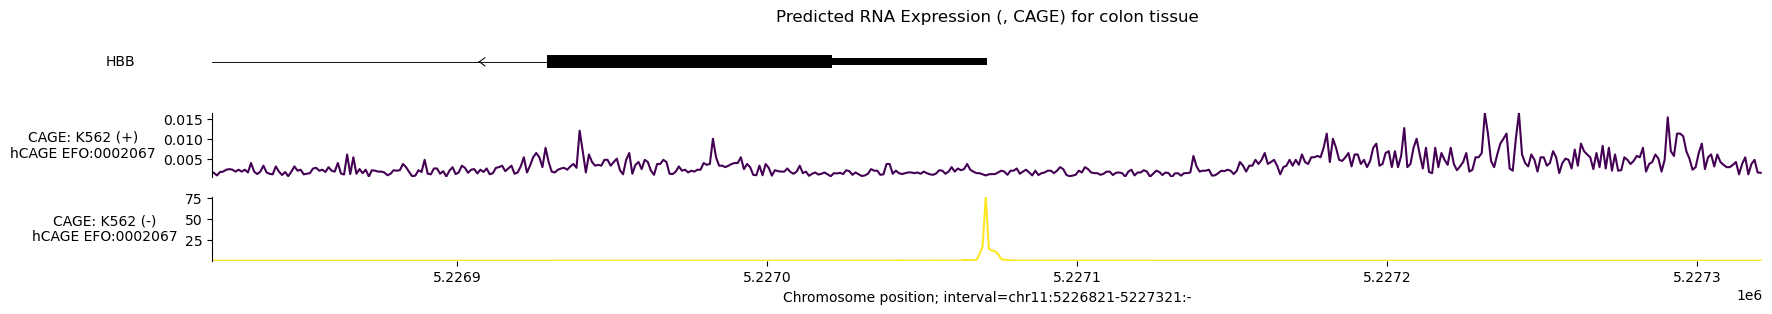

In [23]:
gen_seq_rc=reverse_complement(gen_seq)
gen_output=dna_model.predict_sequence(
    sequence=gen_seq_rc.center(2**20, 'N'),
    requested_outputs=requested_outputs,
    ontology_terms=ontology_terms,
)

gen_cage = TrackData(
    values=gen_output.cage.values,
    metadata=gen_output.cage.metadata,
    interval=interval,
)

plot=plot_components.plot(
    [
        plot_components.TranscriptAnnotation(longest_transcripts),
        plot_components.Tracks(
            tdata=gen_cage,
            ylabel_template='CAGE: {biosample_name} ({strand})\n{name}',
        ),
    ],
    # interval=interval.resize(1000),
    # interval=HBB_interval,
    interval=interval_vis.resize(500),
    # interval=interval.resize(dna_client.SEQUENCE_LENGTH_100KB),
    title='Predicted RNA Expression (, CAGE) for colon tissue',
)

In [24]:
seq_iter00, seq_iter10, seq_iter20, seq_iter30 = reverse_complement(promo_iter00+seq_normalized), reverse_complement(promo_iter10+seq_normalized), reverse_complement(promo_iter20+seq_normalized), reverse_complement(promo_iter30+seq_normalized)

output_iter00=dna_model.predict_sequence(
    sequence=seq_iter00.center(2**20, 'N'),
    requested_outputs=requested_outputs,
    ontology_terms=ontology_terms,
)
output_iter10=dna_model.predict_sequence(
    sequence=seq_iter10.center(2**20, 'N'),
    requested_outputs=requested_outputs,
    ontology_terms=ontology_terms,
)
output_iter20=dna_model.predict_sequence(
    sequence=seq_iter20.center(2**20, 'N'),
    requested_outputs=requested_outputs,
    ontology_terms=ontology_terms,
)
output_iter30=dna_model.predict_sequence(
    sequence=seq_iter30.center(2**20, 'N'),
    requested_outputs=requested_outputs,
    ontology_terms=ontology_terms,
)

In [25]:
track_data_00=TrackData(
    values=output_iter00.cage.values,
    metadata=output_iter00.cage.metadata,
    interval=interval
)
track_data_10=TrackData(
    values=output_iter10.cage.values,
    metadata=output_iter10.cage.metadata,
    interval=interval
)
track_data_20=TrackData(
    values=output_iter20.cage.values,
    metadata=output_iter20.cage.metadata,
    interval=interval
)
track_data_30=TrackData(
    values=output_iter30.cage.values,
    metadata=output_iter30.cage.metadata,
    interval=interval
)

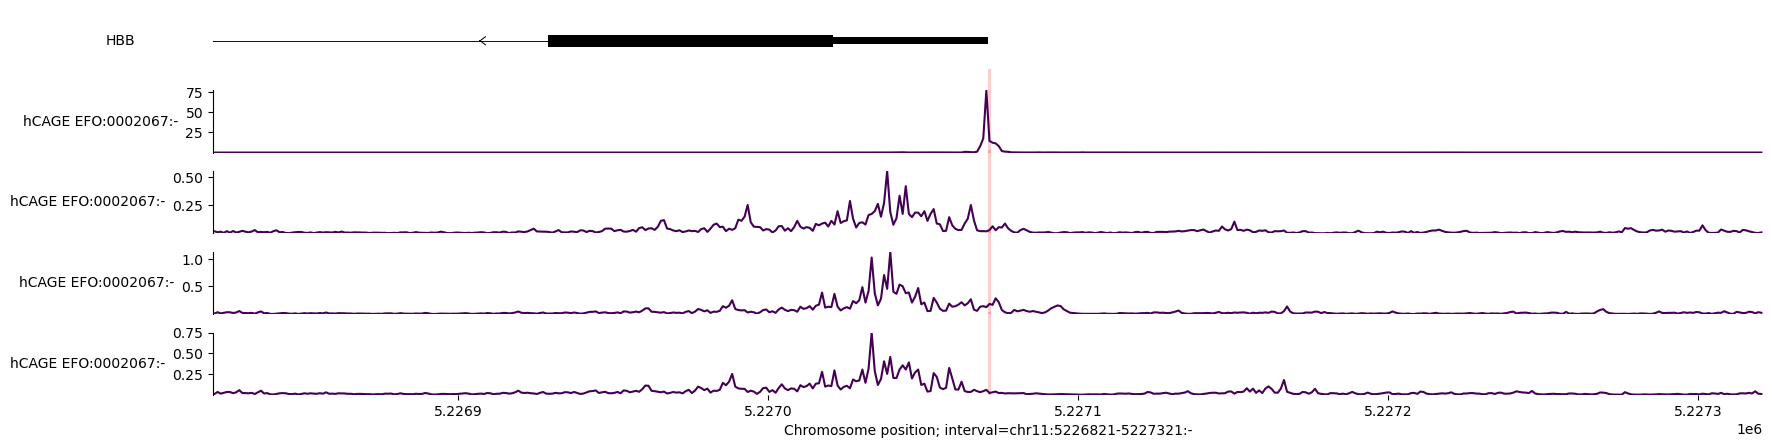

In [38]:
plot_components.plot(
    components=[
        plot_components.TranscriptAnnotation(longest_transcripts,),
        plot_components.Tracks(
            track_data_00.filter_to_negative_strand(),
            shared_y_scale=True
        ),
        plot_components.Tracks(
            track_data_10.filter_to_negative_strand(),
            shared_y_scale=True
        ),
        plot_components.Tracks(
            track_data_20.filter_to_negative_strand(),
            shared_y_scale=True
        ),
        plot_components.Tracks(
            track_data_30.filter_to_negative_strand(),
            shared_y_scale=True
        ),
    ],
    annotations=[plot_components.IntervalAnnotation([genome.Interval(chrom, end, end+1, name="TSS")], colors='red')],
    interval=interval_vis.resize(500),
)
plt.show()

The results are decaying during iterative MLM  
Peak is getting low and the distribution becomes wide

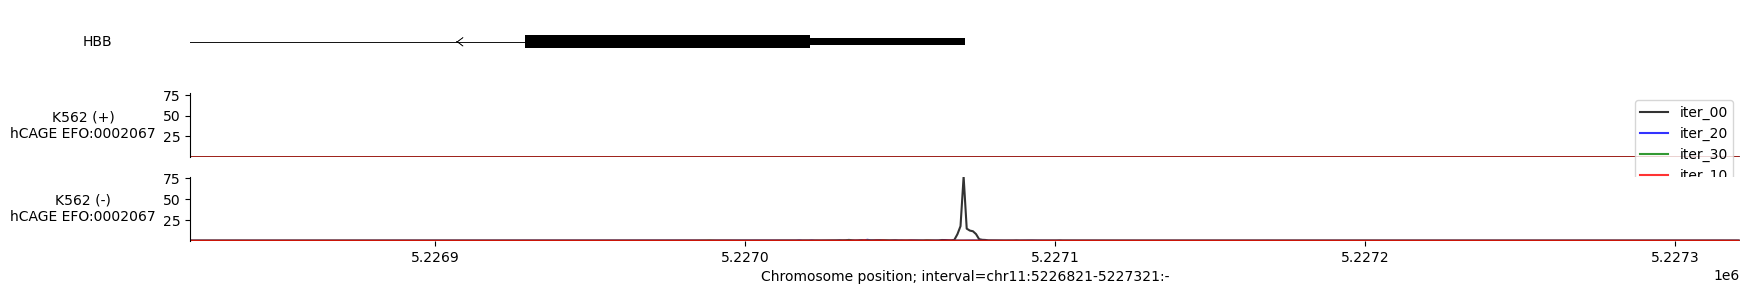

In [27]:
plot_components.plot(
    [
        plot_components.TranscriptAnnotation(longest_transcripts,),
        plot_components.OverlaidTracks(
            tdata={
                # 'iter_00': output_iter00.cage.filter_to_negative_strand,
                'iter_00': track_data_00,
                'iter_10': track_data_10,
                'iter_20': track_data_20,
                'iter_30': track_data_30
            },
            colors={
                'iter_00': 'black',
                'iter_10': 'red',
                'iter_20': 'blue',
                'iter_30': 'green',
            },
            ylabel_template='{biosample_name} ({strand})\n{name}',
            shared_y_scale=True
        ),
    ],
    interval=interval_vis.resize(500),
    # title="",
)
plt.show()

## Other Method: use variant!
AlphaGenome supports variant prediction.
They support not only single variant, but also indel or substitution of long sequences!  
(IDK how long variants they are supporting...)  
  
+) better visualization...!

In [28]:
variant_string=f'{chrom}:{end}:{reverse_complement(promo_iter00)}>{reverse_complement(promo_iter20)}'
variant=genome.Variant.from_str(variant_string)
variant

Variant(chromosome='chr11', position=5227071, reference_bases='TAAGCAATAGATGGCTCTGCCCTGACTTTTATGCCCAGCCCTGGCTCCTGCCCTCCCTGCTCCTGGGAGTAGATTGGCCAACCCTAGGGTGTGGCTCCACAGGGTGAGGTCTAAGTGATGACAGCCGTACCTGTCCTTGGCTCTTCTGGCACTGGCTTAGGAGTTGGACTTCAAACCCTCAGCCCTCCCTCTAAGATATATCTCTTGGCCCCATACCATCAGTACAAATTGCTACTAAAAACATCCTCCTTTGCAAGTGTATTTACGTAATATTTGGAATCACAGCTTGGTAAGCATATTGAAGATCGTTTTCCCAATTTTCTTATTACACAAATAAGAAGTTGATGCACTAAAAGTGGAAGAGTTTTGTCTACCATAATTCAGCTTTGGGATATGTAGATGGATCTCTTCCTGCGTCTCCAGAATATGCAAAATACTTACAGGACAGAATGGATGAAAACTCTACCTCGGTTCTAAGCATATCTTCTCCTTATTTGGATTAAAACCTTCTGGTAAGAAAAGAAAAAATATATATATATATGTGTGTATATATACACACATACATATACATATATATGCATTCATTTGTTGTTGTTTTTCTTAATTTGCTCATGCATGCTAATAAATTATGTCTAAAAATAGAATAAATACAAATCAATGTGCTCTGTGCATTAGTTACTTATTAGGTTTTGGGAAACAAGAGATAAAAAACTAGAGACCTCTTAATGCAGTCAAAAATACAAATAAATAAAAAGTCACTTACAACCCAAAGTGTGACTATCAATGGGGTAATCAGTGGTGTCAAATAGGAGGTTAACTGGGGACATCTAACTGTTTCTGCCTGGACTAATCTGCAAGAGTGTCTGGGGGAACAAAAAGCCTCTGTGACTTAGAAAGTAGGGGTAGGAGGGGAAAAGGTCTTCTACTTGGCTCAGAT

In [29]:
output = dna_model.predict_variant(
    interval=interval,
    variant=variant,
    requested_outputs={
        # dna_client.OutputType.RNA_SEQ,
        dna_client.OutputType.CAGE,
    },
    ontology_terms=ontology_terms,
)

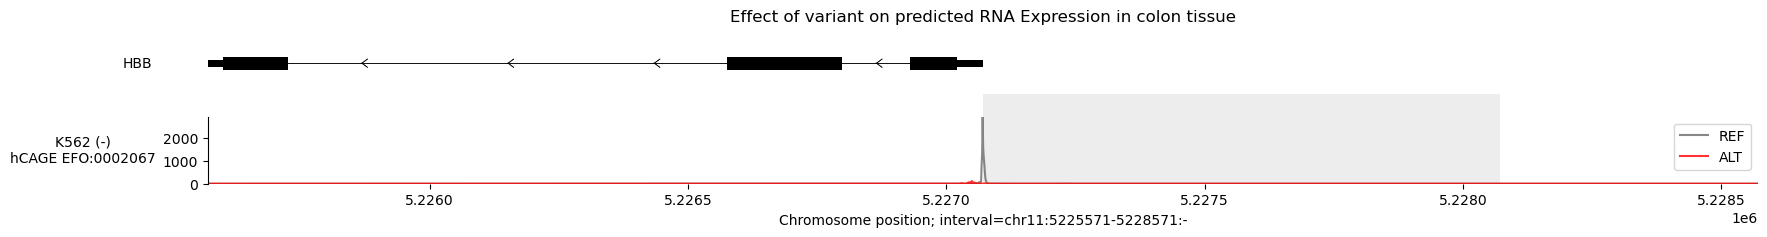

In [30]:
PROMOTER_INTERVAL=[genome.Interval(chrom, end, end+PROMOTER_LENGTH, name='TSS Upstream')]

# Define the colors for REF and ALT predictions.
ref_alt_colors = {'REF': 'dimgrey', 'ALT': 'red'}

# Build plot.
plot = plot_components.plot(
    [
        plot_components.TranscriptAnnotation(longest_transcripts),
        # # RNA-seq tracks.
        # plot_components.OverlaidTracks(
        #     tdata={
        #         'REF': output.reference.rna_seq,
        #         'ALT': output.alternate.rna_seq,
        #     },
        #     colors=ref_alt_colors,
        #     ylabel_template='{biosample_name} ({strand})\n{name}',
        #     shared_y_scale=True
        # ),
        # CAGE track.
        plot_components.OverlaidTracks(
            tdata={
                'REF': output.reference.cage.filter_to_nonpositive_strand(),
                'ALT': output.alternate.cage.filter_to_nonpositive_strand(),
            },
            colors=ref_alt_colors,
            ylabel_template='{biosample_name} ({strand})\n{name}',
            shared_y_scale=True
        ),
    ],
    annotations=[plot_components.IntervalAnnotation(PROMOTER_INTERVAL)],

    # annotations=[plot_components.VariantAnnotation([variant])],
    interval=interval_vis.resize(3000),
    title='Effect of variant on predicted RNA Expression in colon tissue',
)

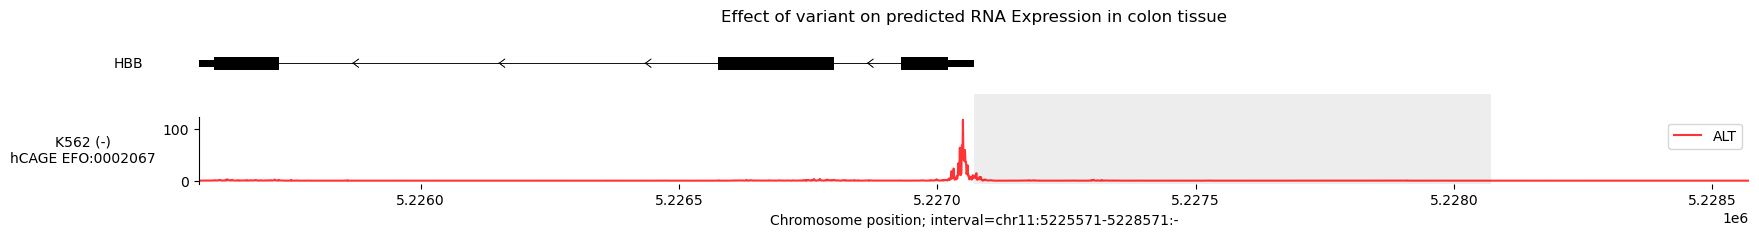

In [31]:

# Define the colors for REF and ALT predictions.
# ref_alt_colors = {'REF': 'dimgrey', 'ALT': 'red'}
ref_alt_colors = {'ALT': 'red'}

# Build plot.
plot = plot_components.plot(
    [
        plot_components.TranscriptAnnotation(longest_transcripts),
        # # RNA-seq tracks.
        # plot_components.OverlaidTracks(
        #     tdata={
        #         # 'REF': output.reference.rna_seq,
        #         'ALT': output.alternate.rna_seq,
        #     },
        #     colors=ref_alt_colors,
        #     ylabel_template='{biosample_name} ({strand})\n{name}',
        # ),
        # CAGE track.
        plot_components.OverlaidTracks(
            tdata={
                # 'REF': output.reference.cage.filter_to_nonpositive_strand(),
                'ALT': output.alternate.cage.filter_to_nonpositive_strand(),
            },
            colors=ref_alt_colors,
            ylabel_template='{biosample_name} ({strand})\n{name}',
        ),
    ],
    annotations=[plot_components.IntervalAnnotation(PROMOTER_INTERVAL)],
    interval=interval_vis.resize(3000),
    title='Effect of variant on predicted RNA Expression in colon tissue',
)

In [32]:
variants=[
    # genome.Variant(chrom, start, ori_seq_rc, seq_iter00),
    genome.Variant(chrom, start, ori_seq_rc, seq_iter10),
    genome.Variant(chrom, start, ori_seq_rc, seq_iter20),
    genome.Variant(chrom, start, ori_seq_rc, seq_iter30),
]

requested_outputs={
    dna_client.OutputType.CAGE,
    dna_client.OutputType.PROCAP,
    dna_client.OutputType.RNA_SEQ
}

outputs=dna_model.predict_variants(
    intervals=interval,
    variants=variants,
    requested_outputs=requested_outputs,
    ontology_terms=ontology_terms,
    progress_bar=True
)

  0%|          | 0/3 [00:00<?, ?it/s]

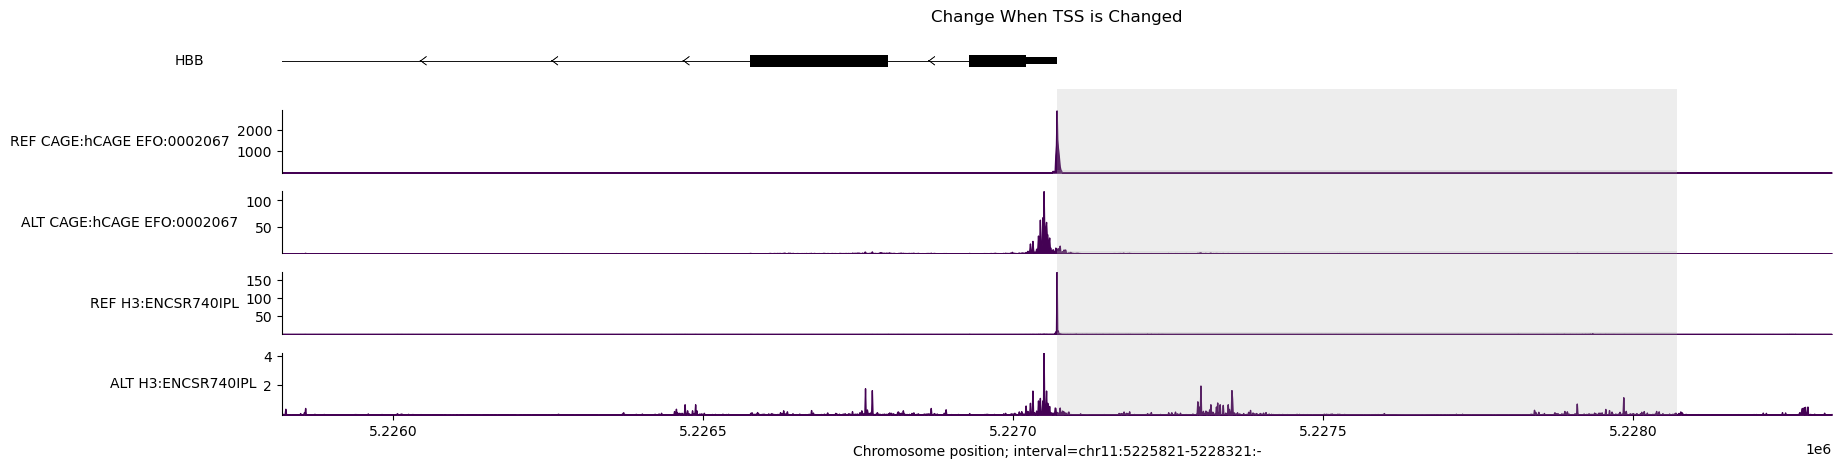

In [33]:
from alphagenome.visualization import plot_components as pc

out = outputs[1]  # 첫 번째 variant
ref_cage = out.reference.cage.filter_to_negative_strand()
alt_cage = out.alternate.cage.filter_to_negative_strand()
ref_procap = out.reference.procap.filter_to_negative_strand()
alt_procap = out.alternate.procap.filter_to_negative_strand()

components = [
    pc.TranscriptAnnotation(longest_transcripts),
    pc.Tracks(ref_cage, filled=True, ylabel_template="REF CAGE:{name}"),
    pc.Tracks(alt_cage, filled=True, ylabel_template="ALT CAGE:{name}"),
    # pc.Tracks(alt_cage - ref_cage, filled=True, ylabel_template="Δ CAGE:{name}"),
    pc.Tracks(ref_procap, filled=True, ylabel_template="REF H3:{name}"),
    pc.Tracks(alt_procap, filled=True, ylabel_template="ALT H3:{name}"),
    # pc.Tracks(alt_procap - ref_procap, filled=True, ylabel_template="Δ H3:{name}"),
]

fig = pc.plot(
    
    components,
    interval=interval_vis.resize(2500),
    annotations=[plot_components.IntervalAnnotation(PROMOTER_INTERVAL)],
    title="Change When TSS is Changed"
    # annotations=[pc.VariantAnnotation([variants[0]])],
)


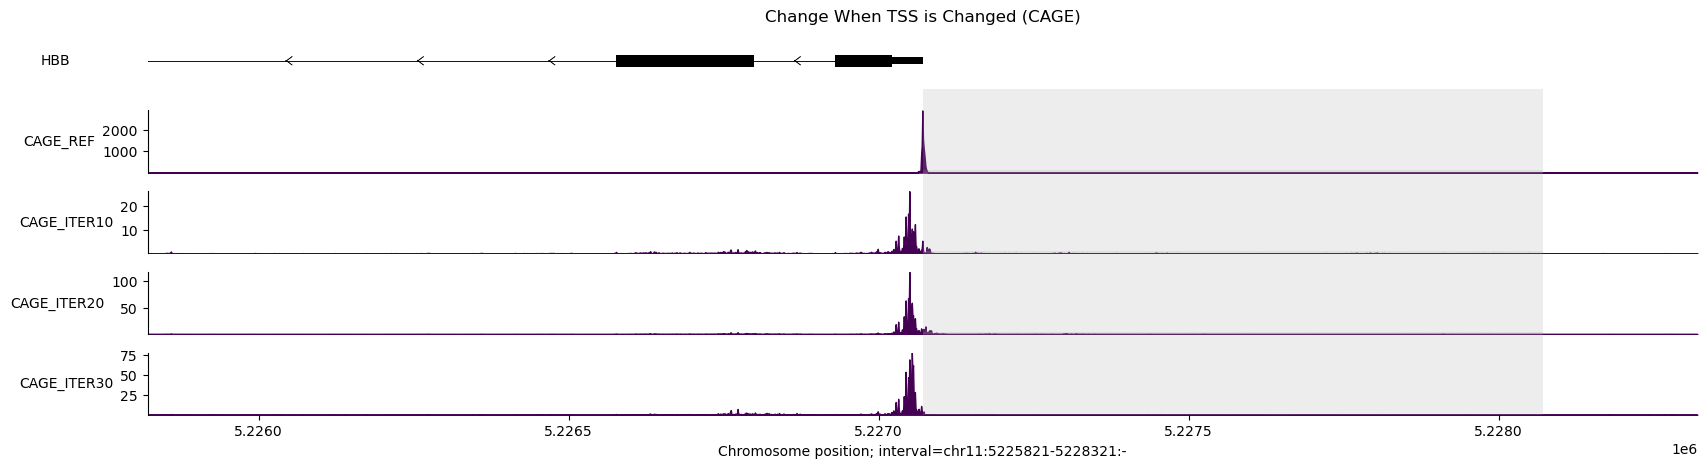

In [34]:
cage_ref=outputs[0].reference.cage.filter_to_negative_strand()
cage_iter10=outputs[0].alternate.cage.filter_to_negative_strand()
cage_iter20=outputs[1].alternate.cage.filter_to_negative_strand()
cage_iter30=outputs[2].alternate.cage.filter_to_negative_strand()

components=[
    pc.TranscriptAnnotation(longest_transcripts),
    pc.Tracks(cage_ref, filled=True, ylabel_template="CAGE_REF"),
    pc.Tracks(cage_iter10, filled=True, ylabel_template="CAGE_ITER10"),
    pc.Tracks(cage_iter20, filled=True, ylabel_template="CAGE_ITER20"),
    pc.Tracks(cage_iter30, filled=True, ylabel_template="CAGE_ITER30"),
]

plot=pc.plot(
    components,
    interval=interval_vis.resize(2500),
    annotations=[plot_components.IntervalAnnotation(PROMOTER_INTERVAL)],
    title="Change When TSS is Changed (CAGE)"
)

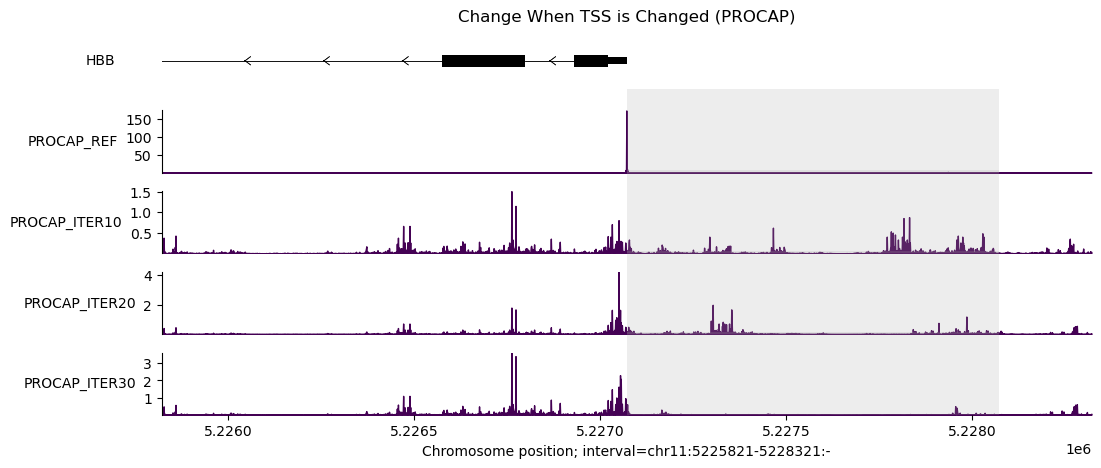

In [35]:
rnaseq_ref=outputs[0].reference.procap.filter_to_negative_strand()
rnaseq_iter10=outputs[0].alternate.procap.filter_to_negative_strand()
rnaseq_iter20=outputs[1].alternate.procap.filter_to_negative_strand()
rnaseq_iter30=outputs[2].alternate.procap.filter_to_negative_strand()

components=[
    pc.TranscriptAnnotation(longest_transcripts),
    pc.Tracks(rnaseq_ref, filled=True, ylabel_template="PROCAP_REF"),
    pc.Tracks(rnaseq_iter10, filled=True, ylabel_template="PROCAP_ITER10"),
    pc.Tracks(rnaseq_iter20, filled=True, ylabel_template="PROCAP_ITER20"),
    pc.Tracks(rnaseq_iter30, filled=True, ylabel_template="PROCAP_ITER30"),
]

plot=pc.plot(
    components,
    interval=interval_vis.resize(2500),
    annotations=[plot_components.IntervalAnnotation(PROMOTER_INTERVAL)],
    title="Change When TSS is Changed (PROCAP)",
    fig_width=12
)

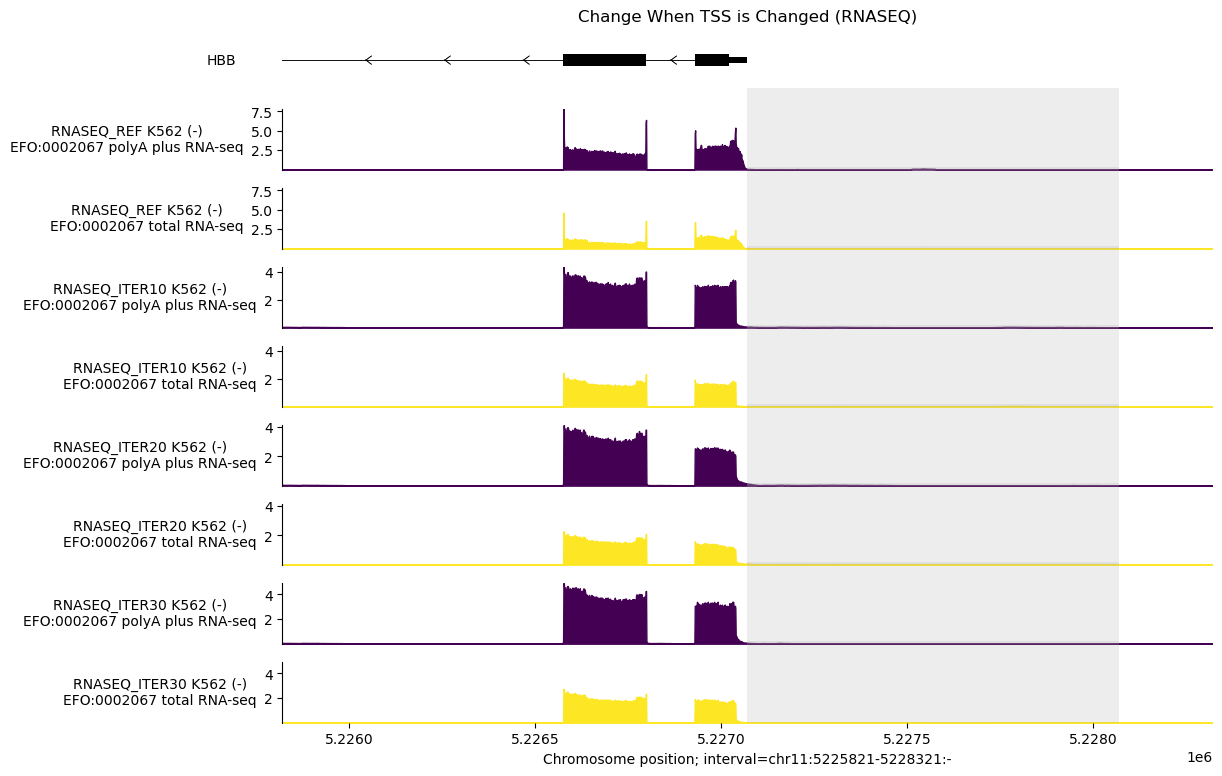

In [36]:
rnaseq_ref=outputs[0].reference.rna_seq.filter_to_negative_strand()
rnaseq_iter10=outputs[0].alternate.rna_seq.filter_to_negative_strand()
rnaseq_iter20=outputs[1].alternate.rna_seq.filter_to_negative_strand()
rnaseq_iter30=outputs[2].alternate.rna_seq.filter_to_negative_strand()

components=[
    pc.TranscriptAnnotation(longest_transcripts),
    pc.Tracks(rnaseq_ref, filled=True, ylabel_template="RNASEQ_REF {biosample_name} ({strand})\n{name}", shared_y_scale=True),
    pc.Tracks(rnaseq_iter10, filled=True, ylabel_template="RNASEQ_ITER10 {biosample_name} ({strand})\n{name}", shared_y_scale=True),
    pc.Tracks(rnaseq_iter20, filled=True, ylabel_template="RNASEQ_ITER20 {biosample_name} ({strand})\n{name}", shared_y_scale=True),
    pc.Tracks(rnaseq_iter30, filled=True, ylabel_template="RNASEQ_ITER30 {biosample_name} ({strand})\n{name}", shared_y_scale=True),
]

plot=pc.plot(
    components,
    interval=interval_vis.resize(2500),
    annotations=[plot_components.IntervalAnnotation(PROMOTER_INTERVAL)],
    title="Change When TSS is Changed (RNASEQ)",
    fig_width=12,
    # despine=False,
    # despine_keep_bottom=False,
    
)

In [37]:
# TODO
# rna-seq은 overlaid 해서 판단을 더 해보는 것도 좋을 듯
# .env + .gitignore 만들어서 api key 숨기기